<a href="https://colab.research.google.com/github/AryanGupta0419/PytorchTutorial/blob/main/DLLAB6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/training_set/training_set/cats/cat.3704.jpg  
  inflating: data/training_set/training_set/cats/cat.3705.jpg  
  inflating: data/training_set/training_set/cats/cat.3706.jpg  
  inflating: data/training_set/training_set/cats/cat.3707.jpg  
  inflating: data/training_set/training_set/cats/cat.3708.jpg  
  inflating: data/training_set/training_set/cats/cat.3709.jpg  
  inflating: data/training_set/training_set/cats/cat.371.jpg  
  inflating: data/training_set/training_set/cats/cat.3710.jpg  
  inflating: data/training_set/training_set/cats/cat.3711.jpg  
  inflating: data/training_set/training_set/cats/cat.3712.jpg  
  inflating: data/training_set/training_set/cats/cat.3713.jpg  
  inflating: data/training_set/training_set/cats/cat.3714.jpg  
  inflating: data/training_set/training_set/cats/cat.3715.jpg  
  inflating: data/training_set/training_set/cats/cat.3716.jpg  
  inflating: data/training_set/training_set/cats/cat.3

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import os


In [5]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
dataset = torchvision.datasets.ImageFolder(root="./data/training_set", transform=transform)


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [7]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 32 * 32, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [8]:
patience = 5
best_val_loss = float("inf")
early_stop_counter = 0
checkpoint_path = "best_model.pth"

In [9]:
num_epochs = 30
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)

    train_acc = 100 * correct_train / total_train
    train_acc_list.append(train_acc)

    # Validation Loop
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Compute validation accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_loss_list.append(avg_val_loss)

    val_acc = 100 * correct_val / total_val
    val_acc_list.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] -> Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Checkpointing: Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✅ Model improved, saving at {checkpoint_path}")
    else:
        early_stop_counter += 1
        print(f"⚠️ No improvement ({early_stop_counter}/{patience})")

    # Early Stopping
    if early_stop_counter >= patience:
        print("🚨 Early stopping triggered!")
        break




Epoch [1/30] -> Train Loss: 0.0035, Train Acc: 99.73%, Val Loss: 0.0000, Val Acc: 100.00%
✅ Model improved, saving at best_model.pth
Epoch [2/30] -> Train Loss: 0.0000, Train Acc: 100.00%, Val Loss: 0.0000, Val Acc: 100.00%
⚠️ No improvement (1/5)
Epoch [3/30] -> Train Loss: 0.0000, Train Acc: 100.00%, Val Loss: 0.0000, Val Acc: 100.00%
⚠️ No improvement (2/5)
Epoch [4/30] -> Train Loss: 0.0000, Train Acc: 100.00%, Val Loss: 0.0000, Val Acc: 100.00%
⚠️ No improvement (3/5)
Epoch [5/30] -> Train Loss: 0.0000, Train Acc: 100.00%, Val Loss: 0.0000, Val Acc: 100.00%
⚠️ No improvement (4/5)
Epoch [6/30] -> Train Loss: 0.0000, Train Acc: 100.00%, Val Loss: 0.0000, Val Acc: 100.00%
⚠️ No improvement (5/5)
🚨 Early stopping triggered!


<ipython-input-10-6ea155bc09e2>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


✅ Best model loaded!


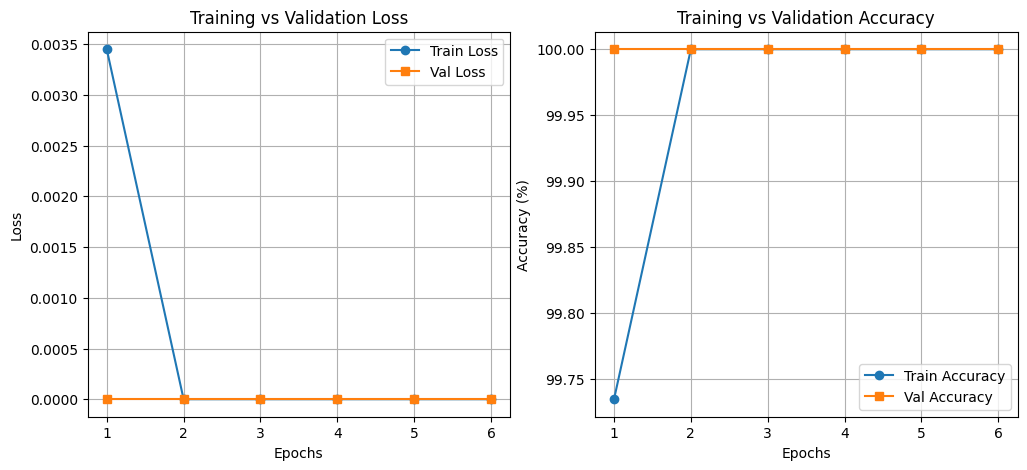

In [10]:
model.load_state_dict(torch.load(checkpoint_path))
print("✅ Best model loaded!")


fig, axs = plt.subplots(1, 2, figsize=(12, 5))


axs[0].plot(range(1, len(train_loss_list) + 1), train_loss_list, label="Train Loss", marker='o')
axs[0].plot(range(1, len(val_loss_list) + 1), val_loss_list, label="Val Loss", marker='s')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training vs Validation Loss")
axs[0].legend()
axs[0].grid(True)


axs[1].plot(range(1, len(train_acc_list) + 1), train_acc_list, label="Train Accuracy", marker='o')
axs[1].plot(range(1, len(val_acc_list) + 1), val_acc_list, label="Val Accuracy", marker='s')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy (%)")
axs[1].set_title("Training vs Validation Accuracy")
axs[1].legend()
axs[1].grid(True)

plt.show()